<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter04/model_perf_comparison_ensembling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    cross_val_score,
)
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.datasets import fetch_datasets
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from collections import Counter
import matplotlib.pyplot as plt
from numpy import mean
import pandas as pd
import seaborn as sns
import numpy as np
import imblearn
import sklearn

## Synthetic data set prep:

In [2]:
def make_data(sep):
    X, y = make_classification(
        n_samples=5000,
        n_features=2,
        n_redundant=0,
        n_clusters_per_class=1,
        weights=[0.92],
        class_sep=sep,  # how separate the classes are
        random_state=1,
    )

    # trasform arrays into pandas df and series
    X = pd.DataFrame(X, columns=["feature_1", "feature_2"])
    y = pd.Series(y)

    return X, y

0    4581
1     419
dtype: int64


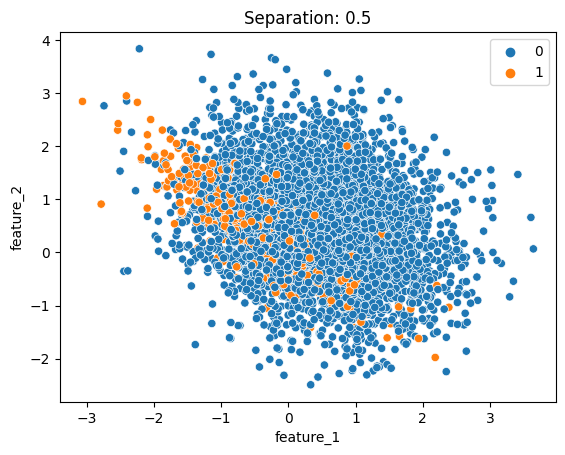

0    4581
1     419
dtype: int64


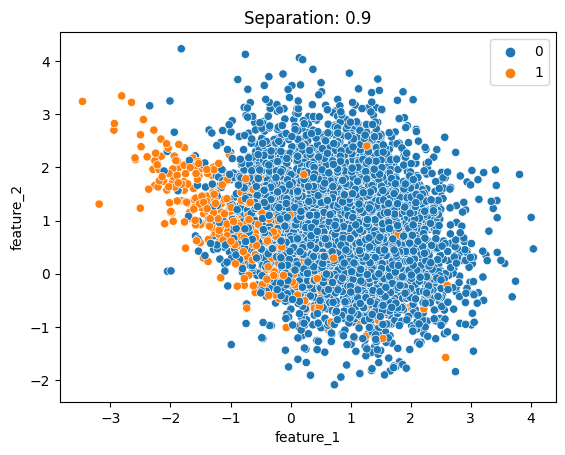

In [3]:
# make datasets with different class separateness
# and plot
synthetic_datasets = []
for sep in [0.5, 0.9]:
    X, y = make_data(sep)
    synthetic_datasets.append(
        {
            "data": np.array(X),
            "target": np.array(y),
            "DESCR": "synthetic data, sep: " + str(sep),
        }
    )
    print(y.value_counts())
    sns.scatterplot(data=X, x="feature_1", y="feature_2", hue=y)
    plt.title("Separation: {}".format(sep))
    plt.show()

## Real world data set

In [4]:
# these datasets are baked into imbalanced-learn
dataset_list = ["thyroid_sick", "abalone_19"]

In [5]:
# print class imbalance of each dataset
all_datasets = []
all_datasets = synthetic_datasets
le = LabelEncoder()
for dataset in dataset_list:
    data = fetch_datasets()[dataset]
    data["target"] = le.fit_transform(data["target"])
    all_datasets.append(data)

for item in all_datasets:
    print(Counter(item["target"]))

Counter({0: 4581, 1: 419})
Counter({0: 4581, 1: 419})
Counter({0: 3541, 1: 231})
Counter({0: 4145, 1: 32})


In [6]:
# function to train random forests and evaluate the performance
# set up a scaler
# (as the oversampling techniques use KNN
# we put the variables in the same scale)
scaler = MinMaxScaler()


# ***with cross-validation***
def run_model(classifier, X_train, y_train):
    model = Pipeline(steps=[("minMaxScaling", scaler), ("model", classifier)])

    # When we make a pipeline and then run the training of the model
    # with cross-validation, the procedure works as follows:

    # 1) take 2 of the 3 fold as train set
    # 2) resample the 2 fold (aka, the train set)
    # 3) train the model on the resampled data from point 2
    # 4) evaluate performance on the 3rd fold, that was not resampled

    # this way, we make sure that we are not evaluating the performance
    # of our classifier on the under-sampled data

    # RepeatedStratifiedKFold is used to retain the balance in each fold
    folds = RepeatedStratifiedKFold(n_splits=15, n_repeats=3, random_state=1)
    cv_results = cross_val_score(
        model, X_train, y_train, scoring="average_precision", cv=folds, n_jobs=-1
    )
    print("model: ", type(classifier).__name__, " | cv_results:", mean(cv_results))
    return mean(cv_results)

In [7]:
def find_ratio(y):
    return float(np.sum(y == 0)) / np.sum(y == 1)


def get_models(y):
    return {
        "LogisticRegression": LogisticRegression(random_state=0, max_iter=2000),
        "XGBoost": XGBClassifier(scale_pos_weight=1),
        "Bagging": sklearn.ensemble.BaggingClassifier(),
        "UnderBagging": imblearn.ensemble.BalancedBaggingClassifier(),  # this uses RandomUnderSampler by default
        "OverBagging": imblearn.ensemble.BalancedBaggingClassifier(
            sampler=imblearn.over_sampling.RandomOverSampler()
        ),  # TODO: check if this correct
        "SMOTEBagging": imblearn.ensemble.BalancedBaggingClassifier(
            sampler=imblearn.over_sampling.SMOTE()
        ),  # TODO: check if this correct
        "Boosting": sklearn.ensemble.AdaBoostClassifier(),
        "RUSBoost": imblearn.ensemble.RUSBoostClassifier(),
        "EasyEnsemble": imblearn.ensemble.EasyEnsembleClassifier(),
    }

In [8]:
pr_mean_dict = {}

for data in all_datasets:
    print("Dataset description: ", data["DESCR"])
    pr_mean_dict[data["DESCR"]] = {}

    model_dict = get_models(data["target"])

    for model_name in model_dict:
        aps_mean_lr = run_model(model_dict[model_name], data["data"], data["target"])
        pr_mean_dict[data["DESCR"]][model_name] = aps_mean_lr

    print()

Dataset description:  synthetic data, sep: 0.5
model:  LogisticRegression  | cv_results: 0.2712444699583669
model:  XGBClassifier  | cv_results: 0.30175037234511964
model:  BaggingClassifier  | cv_results: 0.21844934558000012
model:  BalancedBaggingClassifier  | cv_results: 0.2537117140315513
model:  BalancedBaggingClassifier  | cv_results: 0.21606040954148867
model:  BalancedBaggingClassifier  | cv_results: 0.20637209165556228
model:  AdaBoostClassifier  | cv_results: 0.2372674943511803
model:  RUSBoostClassifier  | cv_results: 0.2236003693679508
model:  EasyEnsembleClassifier  | cv_results: 0.27480534230675363

Dataset description:  synthetic data, sep: 0.9
model:  LogisticRegression  | cv_results: 0.6328843652552555
model:  XGBClassifier  | cv_results: 0.6037342560956372
model:  BaggingClassifier  | cv_results: 0.5132319183271034
model:  BalancedBaggingClassifier  | cv_results: 0.5099083654950328
model:  BalancedBaggingClassifier  | cv_results: 0.5254777670436417
model:  BalancedBag

In [9]:
from IPython.display import display

pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

print("\033[1m Average Precision")
df = pd.DataFrame(pr_mean_dict)
display(df)

 Average Precision


,"synthetic data, sep: 0.5","synthetic data, sep: 0.9",thyroid_sick,abalone_19
LogisticRegression,0.271244,0.632884,0.578898,0.057512
XGBoost,0.301750,0.603734,0.968183,0.127415
Bagging,0.218449,0.513232,0.932110,0.050302
UnderBagging,0.253712,0.509908,0.882989,0.048421
OverBagging,0.216060,0.525478,0.942707,0.078012
SMOTEBagging,0.206372,0.506899,0.943360,0.069981
Boosting,0.237267,0.596778,0.792852,0.069021
RUSBoost,0.223600,0.544239,0.703041,0.058125
EasyEnsemble,0.274805,0.643125,0.669800,0.091877


----------------------------------------------------------------

Table 1: Average preicision scores on synthetic data, sep: 0.5
----------------------------------------------------------------

                    average_precision
LogisticRegression               0.27
XGBoost                          0.30
Bagging                          0.22
UnderBagging                     0.25
OverBagging                      0.22
SMOTEBagging                     0.21
Boosting                         0.24
RUSBoost                         0.22
EasyEnsemble                     0.27
----------------------------------------------------------------

Table 2: Average preicision scores on synthetic data, sep: 0.9
----------------------------------------------------------------

                    average_precision
LogisticRegression               0.63
XGBoost                          0.60
Bagging                          0.51
UnderBagging                     0.51
OverBagging                      0.53
SM

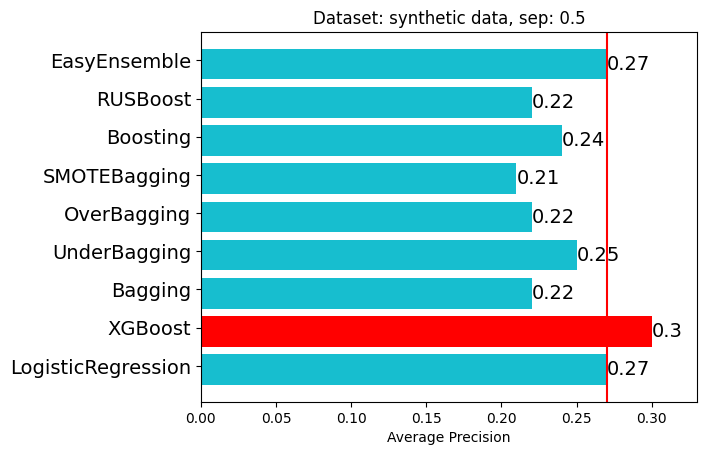

----------------------------------------------------------------

Figure 2: Average preicision scores on synthetic data, sep: 0.9
----------------------------------------------------------------



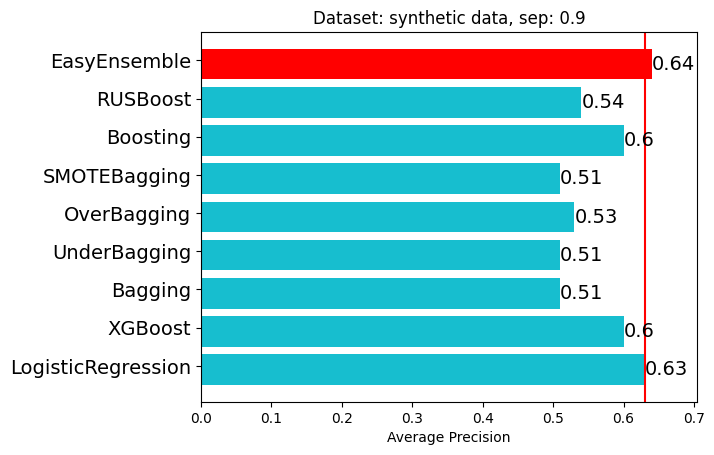

----------------------------------------------------------------

Figure 3: Average preicision scores on thyroid_sick
----------------------------------------------------------------



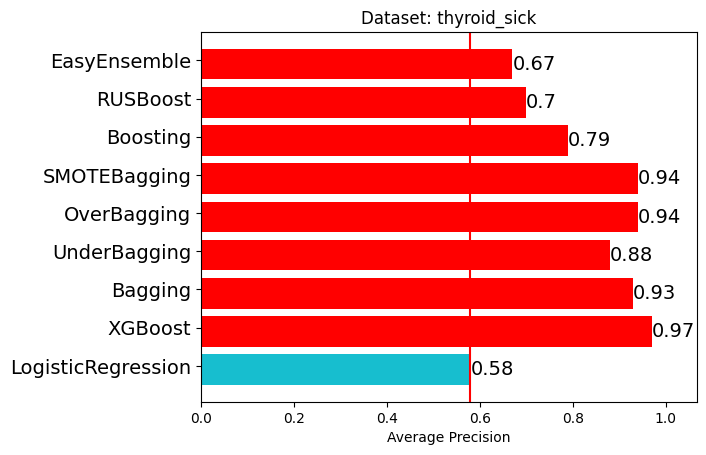

----------------------------------------------------------------

Figure 4: Average preicision scores on abalone_19
----------------------------------------------------------------



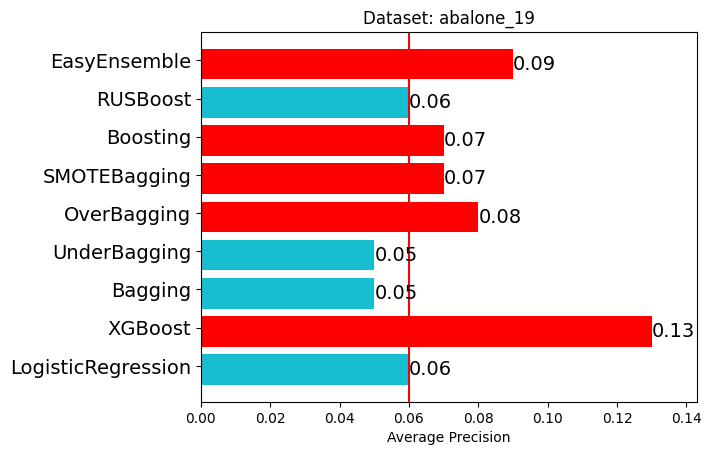

In [12]:
# Now we plot the performance of the model in the
for i, dataset in enumerate(all_datasets):
    print("----------------------------------------------------------------\n")
    print(
        "Table "
        + str(i + 1)
        + ": Average preicision scores on "
        + str((all_datasets[i]["DESCR"]))
    )
    print("----------------------------------------------------------------\n")
    pr_mean_s = pd.Series(pr_mean_dict[dataset["DESCR"]]).round(2)
    df = pd.DataFrame([pr_mean_s], index=["average_precision"]).T
    print(df)

for i, dataset in enumerate(all_datasets):
    print("----------------------------------------------------------------\n")
    print(
        "Figure "
        + str(i + 1)
        + ": Average preicision scores on "
        + str((all_datasets[i]["DESCR"]))
    )
    print("----------------------------------------------------------------\n")
    df = pd.Series(pr_mean_dict[dataset["DESCR"]]).round(2)

    colors = []
    colors.append("#17becf")
    for j in range(1, 9):
        if df[j] > df["LogisticRegression"]:
            colors.append("r")
        else:
            colors.append("#17becf")

    r = np.arange(9)  # plotting for 9 different ensembling techniques
    fig, ax = plt.subplots()
    ax.barh(r, df, align="center", color=colors)
    ax.set_xlabel("Average Precision")
    plt.axvline(df["LogisticRegression"], color="r")
    plt.yticks(
        [r + 0.1 for r in range(9)],
        [
            "LogisticRegression",
            "XGBoost",
            "Bagging",
            "UnderBagging",
            "OverBagging",
            "SMOTEBagging",
            "Boosting",
            "RUSBoost",
            "EasyEnsemble",
        ],
        fontsize=14,
    )
    maximum = df.max()
    plt.xlim(0, maximum + 0.10 * maximum)
    plt.title("Dataset: %s" % (all_datasets[i]["DESCR"]))
    ax.bar_label(ax.containers[0], fontsize=14)
    plt.show()